In [1]:
!pip install -q sqlalchemy psycopg2 tqdm optuna category_encoders catboost

**ТЗ:**

Задача проекта - построить модель бинарной классификации исхода матча в игре Dota 2.

В Dota 2 участвуют две команды: Radiant и Dire. Нужно оценить вероятность победы команды Radiant. 

В обычной игре Dota 2 каждая из двух команд — Radiant и Dire — состоит из 5 игроков. Каждый игрок выбирает героя, который играет определённую роль. Dota 2 — командная игра, поэтому состав команды имеет большое значение. Карта игры содержит базы команд (фонтан), 3 линии для каждой стороны, магазины, логово Рошана и другие элементы.
В течение игры игроки улучшают своих героев, покупают предметы, разрушают башни, убивают героев противника, фармят крипов врага и "отрекаются" от своих крипов (не дают их убивать врагу). Цель игры — разрушить фонтан противника, и ничья невозможна.

Для оценки используется метрика ROC-AUC. Результат этой задачи — бинарный: для каждой игры нужно предсказать победу команды Radiant (1) или поражение (0). Поскольку мы оцениваем вероятность исхода, результат будет находиться в интервале [0,1]. Затем это значение сравнивается с определённым порогом для получения бинарного ответа.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import math
import numpy as np

from IPython.display import display
from sqlalchemy import create_engine
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import TargetEncoder
from catboost import CatBoostClassifier

In [4]:
RANDOM_STATE = 42
N_TRIALS = 25

**0. Загрузка данных**

In [6]:
def load_jsonl_with_progress(filepath):
    # Функция построчного считывания JSON файла
    data = []
    with open(filepath, 'r') as f:
        for line in tqdm(f, desc=f"Loading {filepath}"):
            data.append(json.loads(line.strip()))
    return pd.DataFrame(data)

Для подключения к БД используются следующие параметры

In [8]:
db_params = {
    'dbname': 'dota_2',
    'user': 'student',
    'password': 'uvBbBm8gn',
    'host': '158.160.146.146',
    'port': '5432'
}

connection_string = (
    f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@"
    f"{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
)

engine = create_engine(
    connection_string,
    pool_size=5,
    max_overflow=10
)

query_train_features = "SELECT * FROM train_features;"
query_train_target = "SELECT * FROM train_targets;"
query_test_features = "SELECT * FROM test_features;"


with engine.connect() as connection:
    
    df_train_features_raw = pd.read_sql_query(query_train_features, connection)
    df_train_target_raw = pd.read_sql_query(query_train_target, connection)
    df_test_features_raw = pd.read_sql_query(query_test_features, engine)
    
engine.dispose()

Подключение к БД и выгрузка необходимых данных

In [10]:
# df_train_raw_json = load_jsonl_with_progress('train_matches.jsonl')
# df_test_raw_json = load_jsonl_with_progress('test_matches.jsonl')

Загрузка данных из JSON файла

Данные загружены, можно приступать к их обработке

**1. Исследовательский анализ данных**

In [14]:
def display_data(data):
    # Функция вывода необходимой информации по датафрейму
    display(data.head(5))
    display(data.info())
    display(data.describe())

In [15]:
def create_stat_plots(data, target):
    # Функция вывода графика распределения значений признака
    if pd.api.types.is_numeric_dtype(data[target]):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        sns.histplot(data[target], bins=30, kde=True, ax=ax1)
        ax1.set_title(f'Histogram of {target}')
        sns.boxplot(x=data[target], ax=ax2)
        ax2.set_title(f'Box Plot for {target}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Столбец {target} имеет неверный тип данных")

    print(data[target].describe())

In [16]:
def delete_outliers(data, target):
    # Функция удаления выбросов из признака
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[target] >= lower_bound) & (data[target] <= upper_bound)]
    print('Удаляю выбросы')
    return data

In [17]:
def change_reg_to_cat(feature, large=False):
    # Функция изменения списка для фичи с численных признаков на категориальные
    try:
        numeric_features.remove(feature)
        if large:
            categorical_features_large.append(feature)
        else:
            categorical_features.append(feature)
    except: 
        print(f'В numeric_features нет {feature}')

In [18]:
display_data(df_train_features_raw)

match_id_hash  game_time  game_mode  lobby_type  \
0  887fd54490a9cd084b4a40942d82841f        779         22           0   
1  1319117a7e58c81b75d7a1366cfe26f5       1693         22           7   
2  cae9bb31f8792940fbe3111bb4eb01ee       1214          4           0   
3  100509b185cd0c699cbd8611c2a27c9d       2689         22           0   
4  25b6009d53313fe56c6e59686f8c6fcd        967         22           0   

   objectives_len  chat_len  r1_hero_id  r1_kills  r1_deaths  r1_assists  ...  \
0               1         0          44         0          3           3  ...   
1               9         5           8         1          3           7  ...   
2               4         0          52         2          6           8  ...   
3              17        53          30         3         12          25  ...   
4               1         8           5         3          2           9  ...   

    d5_stuns  d5_creeps_stacked  d5_camps_stacked  d5_rune_pickups  \
0   0.000000                  0                 0                3   
1  12.663574                  4                 1                4   
2   0.000000                  0                 0                5   
3   6.221230                  0                 0               14   
4   0.000000                  0                 0                8   

   d5_firstblood_claimed  d5_teamfight_participation  d5_towers_killed  \
0                      0                    0.222222                 0   
1                      0                    0.481482                 2   
2                      0                    0.375000                 0   
3                      0                    0.574074                 0   
4                      0                    0.555556                 0   

   d5_roshans_killed  d5_obs_placed  d5_sen_placed  
0                  0              2              2  
1                  0              1              0  
2                  0              0              0  
3                  0              1              0  
4                  0              3              2  

[5 rows x 246 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33723 entries, 0 to 33722
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 63.3+ MB


None

game_time     game_mode    lobby_type  objectives_len      chat_len  \
count  33723.000000  33723.000000  33723.000000    33723.000000  33723.000000   
mean    1145.966077     19.584112      4.772944        6.530143      7.321502   
std      767.572763      6.307268      3.260357        6.501226     13.304097   
min        0.000000      2.000000      0.000000        0.000000      0.000000   
25%      521.000000     22.000000      0.000000        1.000000      0.000000   
50%     1044.000000     22.000000      7.000000        4.000000      3.000000   
75%     1655.500000     22.000000      7.000000       10.000000      9.000000   
max     4742.000000     23.000000      7.000000       43.000000    291.000000   

         r1_hero_id      r1_kills     r1_deaths    r1_assists     r1_denies  \
count  33723.000000  33723.000000  33723.000000  33723.000000  33723.000000   
mean      51.095751      3.144708      3.275183      4.666815      6.271328   
std       34.570217      3.736906      3.288359      5.232222      8.173442   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       20.000000      0.000000      1.000000      1.000000      1.000000   
50%       44.000000      2.000000      2.000000      3.000000      3.000000   
75%       81.000000      5.000000      5.000000      7.000000      9.000000   
max      120.000000     32.000000     27.000000     40.000000     84.000000   

       ...      d5_stuns  d5_creeps_stacked  d5_camps_stacked  \
count  ...  33723.000000       33723.000000      33723.000000   
mean   ...     11.788077           1.047772          0.346262   
std    ...     20.660275           3.562469          0.970499   
min    ...     -6.191284           0.000000          0.000000   
25%    ...      0.000000           0.000000          0.000000   
50%    ...      1.505127           0.000000          0.000000   
75%    ...     16.023252           0.000000          0.000000   
max    ...    277.618070         132.000000         29.000000   

       d5_rune_pickups  d5_firstblood_claimed  d5_teamfight_participation  \
count     33723.000000           33723.000000                33723.000000   
mean          4.672419               0.089909                    0.415586   
std           4.654679               0.286056                    0.267576   
min           0.000000               0.000000                    0.000000   
25%           1.000000               0.000000                    0.235294   
50%           3.000000               0.000000                    0.441176   
75%           7.000000               0.000000                    0.596154   
max          57.000000               1.000000                    2.000000   

       d5_towers_killed  d5_roshans_killed  d5_obs_placed  d5_sen_placed  
count      33723.000000       33723.000000   33723.000000   33723.000000  
mean           0.298817           0.024612       1.265546       0.780328  
std            0.727709           0.172855       2.594110       2.447617  
min            0.000000           0.000000       0.000000       0.000000  
25%            0.000000           0.000000       0.000000       0.000000  
50%            0.000000           0.000000       0.000000       0.000000  
75%            0.000000           0.000000       1.000000       0.000000  
max            9.000000           5.000000      26.000000      47.000000  

[8 rows x 245 columns]

Сырой тренировочный датафрейм признаков содержит 33723 строки и 246 столбцов

In [20]:
display_data(df_train_target_raw)

match_id_hash  game_time  radiant_win  duration  \
0  a400b8f29dece5f4d266f49f1ae2e98a        155        False       992   
1  b9c57c450ce74a2af79c9ce96fac144d        658         True      1154   
2  6db558535151ea18ca70a6892197db41         21         True      1503   
3  46a0ddce8f7ed2a8d9bd5edcbb925682        576         True      1952   
4  b1b35ff97723d9b7ade1c9c3cf48f770        453        False      2001   

   time_remaining next_roshan_team  
0             837             None  
1             496             None  
2            1482          Radiant  
3            1376             None  
4            1548             None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33723 entries, 0 to 33722
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   match_id_hash     33723 non-null  object
 1   game_time         33723 non-null  int64 
 2   radiant_win       33723 non-null  bool  
 3   duration          33723 non-null  int64 
 4   time_remaining    33723 non-null  int64 
 5   next_roshan_team  21532 non-null  object
dtypes: bool(1), int64(3), object(2)
memory usage: 1.3+ MB


None

game_time      duration  time_remaining
count  33723.000000  33723.000000    33723.000000
mean    1145.966077   2328.799810     1182.833734
std      767.572763    672.736822      772.098460
min        0.000000    901.000000       31.000000
25%      521.000000   1872.000000      553.000000
50%     1044.000000   2270.000000     1086.000000
75%     1655.500000   2748.000000     1696.000000
max     4742.000000   5638.000000     5108.000000

Сырой тренировочный датафрейм тагргетов содержит 33723 строки и 6 столбцов

In [22]:
display_data(df_test_features_raw)

match_id_hash  game_time  game_mode  lobby_type  \
0  ee84861e709fc9cf5d48ba0f04b7f43b       1807         22           7   
1  a9475ee47c8a10d6cf37c1461814653e       2591         22           7   
2  b56ea18db1408fc68263757232c1facb        958         22           7   
3  9587640246910f0e1b033a6c8f6d8211       2092          4           0   
4  3eb93fbd9056ebdb52ffff84e6c3664a        554         22           7   

   objectives_len  chat_len  r1_hero_id  r1_kills  r1_deaths  r1_assists  ...  \
0              17        12          32         2          5          14  ...   
1              13       106         119        17          9          16  ...   
2               4         0          53         5          2           3  ...   
3              14         2          44         8          8           8  ...   
4               1         0          95         0          0           3  ...   

    d5_stuns  d5_creeps_stacked  d5_camps_stacked  d5_rune_pickups  \
0  12.174799                  0                 0                1   
1  31.994320                  0                 0               12   
2  20.528862                  0                 0                4   
3  27.558594                  0                 0                6   
4  11.663805                  6                 2                6   

   d5_firstblood_claimed  d5_teamfight_participation  d5_towers_killed  \
0                      0                    0.650000                 0   
1                      0                    0.553191                 1   
2                      0                    0.600000                 0   
3                      0                    0.514286                 1   
4                      0                    1.000000                 0   

   d5_roshans_killed  d5_obs_placed  d5_sen_placed  
0                  0              0              0  
1                  0              0              0  
2                  0              4              2  
3                  0              0              0  
4                  0              3              3  

[5 rows x 246 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 11.2+ MB


None

game_time    game_mode   lobby_type  objectives_len     chat_len  \
count  5952.000000  5952.000000  5952.000000     5952.000000  5952.000000   
mean   1146.744120    19.588542     4.768985        6.494960     7.434812   
std     765.192827     6.292502     3.262126        6.440658    13.714671   
min       0.000000     2.000000     0.000000        0.000000     0.000000   
25%     518.000000    22.000000     0.000000        1.000000     0.000000   
50%    1041.000000    22.000000     7.000000        4.000000     3.000000   
75%    1656.250000    22.000000     7.000000       10.000000     9.000000   
max    4933.000000    23.000000     7.000000       41.000000   272.000000   

        r1_hero_id     r1_kills    r1_deaths   r1_assists    r1_denies  ...  \
count  5952.000000  5952.000000  5952.000000  5952.000000  5952.000000  ...   
mean     51.144993     3.165827     3.232695     4.689180     6.393313  ...   
std      34.791420     3.652189     3.254683     5.186636     8.374693  ...   
min       1.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%      19.000000     0.000000     1.000000     1.000000     1.000000  ...   
50%      44.000000     2.000000     2.000000     3.000000     3.000000  ...   
75%      81.000000     5.000000     5.000000     7.000000     8.000000  ...   
max     120.000000    27.000000    22.000000    38.000000    83.000000  ...   

          d5_stuns  d5_creeps_stacked  d5_camps_stacked  d5_rune_pickups  \
count  5952.000000        5952.000000       5952.000000      5952.000000   
mean     11.689735           0.989415          0.325437         4.748992   
std      20.109174           3.370135          0.924346         4.577586   
min      -4.380856           0.000000          0.000000         0.000000   
25%       0.000000           0.000000          0.000000         1.000000   
50%       1.532959           0.000000          0.000000         4.000000   
75%      16.059857           0.000000          0.000000         7.000000   
max     212.326400          75.000000         17.000000        40.000000   

       d5_firstblood_claimed  d5_teamfight_participation  d5_towers_killed  \
count            5952.000000                 5952.000000       5952.000000   
mean                0.091398                    0.418082          0.305444   
std                 0.288198                    0.267422          0.759049   
min                 0.000000                    0.000000          0.000000   
25%                 0.000000                    0.239524          0.000000   
50%                 0.000000                    0.444444          0.000000   
75%                 0.000000                    0.600000          0.000000   
max                 1.000000                    1.666667          7.000000   

       d5_roshans_killed  d5_obs_placed  d5_sen_placed  
count        5952.000000    5952.000000    5952.000000  
mean            0.023353       1.290491       0.800067  
std             0.156500       2.617070       2.382584  
min             0.000000       0.000000       0.000000  
25%             0.000000       0.000000       0.000000  
50%             0.000000       0.000000       0.000000  
75%             0.000000       1.000000       0.000000  
max             2.000000      25.000000      31.000000  

[8 rows x 245 columns]

In [23]:
# display_data(df_train_raw_json)

In [24]:
# display_data(df_test_raw_json)

In [25]:
df_train_features_raw.rename(columns={'game_time_x': 'game_time'}, inplace=True)
df_test_features_raw.rename(columns={'game_time_x': 'game_time'}, inplace=True)

In [26]:
categorical_features = []
categorical_features_large = []
numeric_features = []

for column in df_train_features_raw.columns:
    if pd.api.types.is_numeric_dtype(df_train_features_raw[column]):
        numeric_features.append(column)
    else:
        categorical_features.append(column)

Определю списки количественных и категориальных данных

Построение гистограмм: 245it [00:12, 19.44it/s]


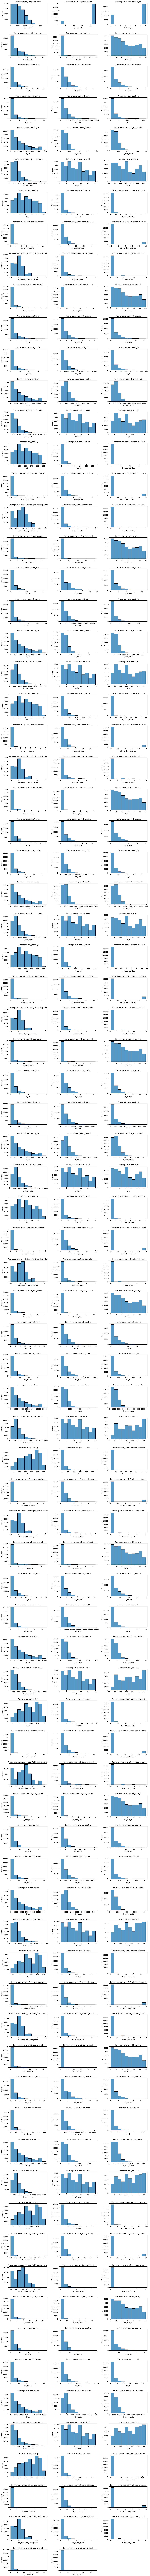

In [28]:
n_cols = 3
n_rows = math.ceil(len(numeric_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
fig.tight_layout(pad=5.0)

for i, column in tqdm(enumerate(numeric_features), desc="Построение гистограмм"):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(df_train_features_raw[column], bins=10, ax=axes[row, col])
    axes[row, col].set_title(f'Гистограмма для {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Частота')

if len(numeric_features) % n_cols != 0:
    for j in range(len(numeric_features) % n_cols, n_cols):
        fig.delaxes(axes[-1, j])

plt.show()

In [29]:
train_data_raw = pd.merge(df_train_features_raw, df_train_target_raw[['match_id_hash', 'radiant_win']], how='inner', on='match_id_hash')

In [30]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33723 entries, 0 to 33722
Columns: 247 entries, match_id_hash to radiant_win
dtypes: bool(1), float64(30), int64(215), object(1)
memory usage: 63.3+ MB


In [31]:
train_data = train_data_raw.copy()
test_data = df_test_features_raw.copy()

Для дальнейшей обработки данных создам новый датафрейм на основании "сырого"

In [33]:
train_data.rename(columns={'game_time_x': 'game_time'}, inplace=True)

In [34]:
# train_data.drop('game_time_y', axis=1)

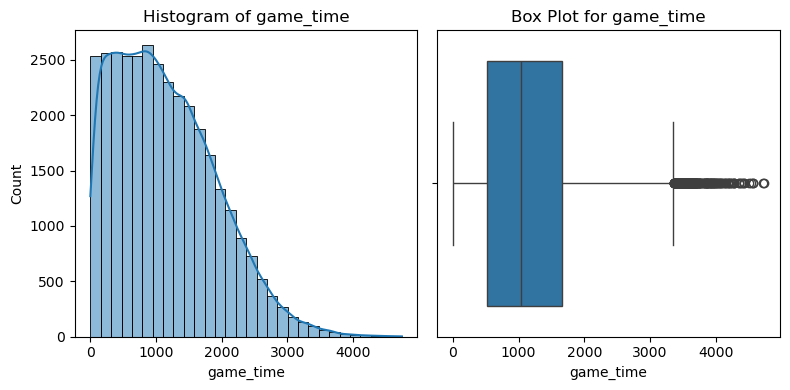

count    33723.000000
mean      1145.966077
std        767.572763
min          0.000000
25%        521.000000
50%       1044.000000
75%       1655.500000
max       4742.000000
Name: game_time, dtype: float64


In [35]:
create_stat_plots(train_data, 'game_time')

Временная метка игры, когда были получены данные

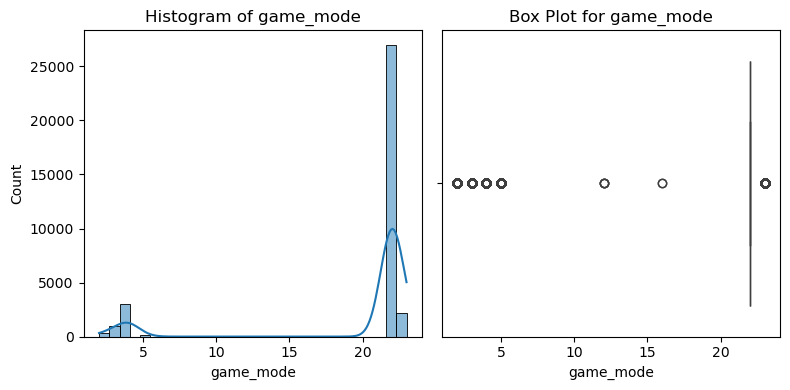

count    33723.000000
mean        19.584112
std          6.307268
min          2.000000
25%         22.000000
50%         22.000000
75%         22.000000
max         23.000000
Name: game_mode, dtype: float64


In [37]:
create_stat_plots(train_data, 'game_mode')

In [38]:
train_data['game_mode'].unique()

array([22,  4, 23,  3,  2,  5, 12, 16], dtype=int64)

In [39]:
change_reg_to_cat('game_mode', large=True)

Очевидно, что из-за типа данных, моя программа оценила эту фичу как регрессионную, однако это классы, и необходимо это изменить. По графику наблюдается дисбаланс классов.

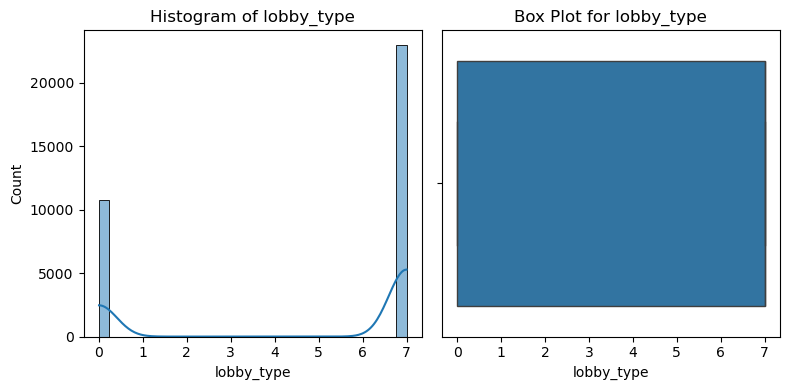

count    33723.000000
mean         4.772944
std          3.260357
min          0.000000
25%          0.000000
50%          7.000000
75%          7.000000
max          7.000000
Name: lobby_type, dtype: float64


In [41]:
create_stat_plots(train_data, 'lobby_type')

In [42]:
train_data['lobby_type'].unique()

array([0, 7], dtype=int64)

In [43]:
change_reg_to_cat('lobby_type')

Очевидно, что из-за типа данных, моя программа оценила эту фичу как регрессионную, однако это классы, и необходимо это изменить. По графику наблюдается дисбаланс классов.

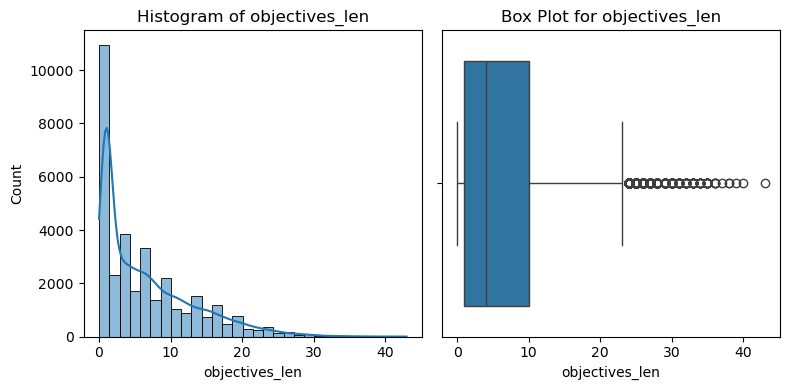

count    33723.000000
mean         6.530143
std          6.501226
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max         43.000000
Name: objectives_len, dtype: float64


In [45]:
create_stat_plots(train_data, 'objectives_len')

Из названия не ясно что это за признак, в документации информации тоже нет. Возможно, имеются ввиду уничтожение общего количества всех построек (с учетом "туалетов" и статуй на базе + убийства Рошана). Тогда максимальное количество 25 (количество уничтожаемых построек) + 3-4 за Рошана. Возможно, что значения за 3 квантилем можно считать выбросами и удалить.

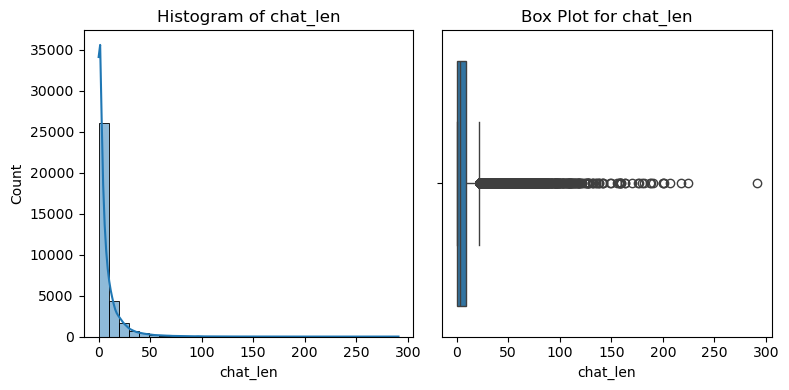

count    33723.000000
mean         7.321502
std         13.304097
min          0.000000
25%          0.000000
50%          3.000000
75%          9.000000
max        291.000000
Name: chat_len, dtype: float64


In [47]:
create_stat_plots(train_data, 'chat_len')

Вероятно, признак описывающий количество сообщений в чате. Много выбросов.

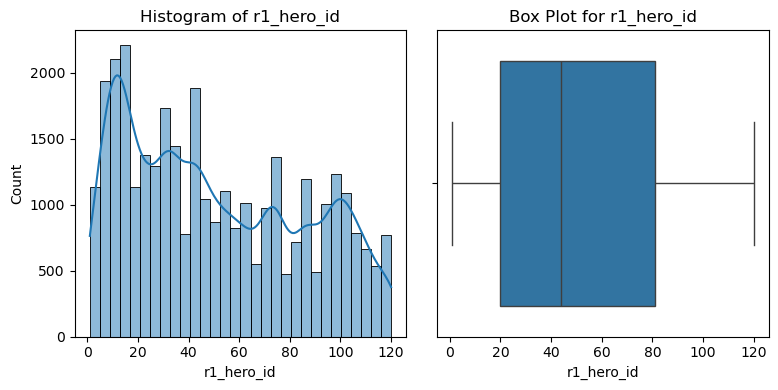

count    33723.000000
mean        51.095751
std         34.570217
min          1.000000
25%         20.000000
50%         44.000000
75%         81.000000
max        120.000000
Name: r1_hero_id, dtype: float64


In [49]:
create_stat_plots(train_data, 'r1_hero_id')

In [50]:
train_data['r1_hero_id']

0        44
1         8
2        52
3        30
4         5
         ..
33718    74
33719    11
33720    19
33721    83
33722    42
Name: r1_hero_id, Length: 33723, dtype: int64

In [51]:
for column in train_data.columns:
    if 'hero_id' in column:
        change_reg_to_cat(column, large=True)

Несмотря на большое количество уникальных значений, этот признак является категориальным, так же сделаю для всех подобных признаков других игроков

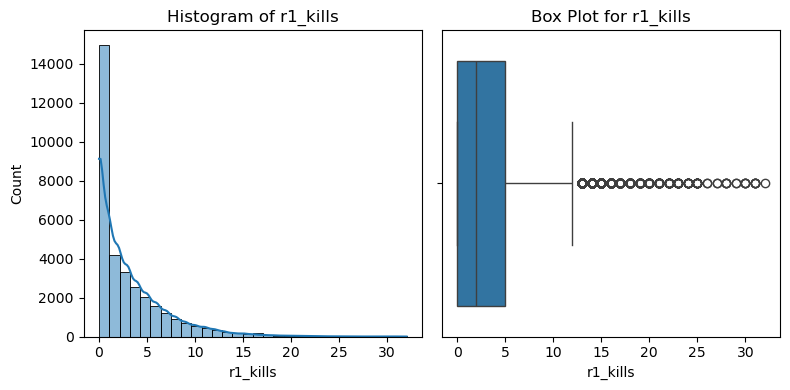

count    33723.000000
mean         3.144708
std          3.736906
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max         32.000000
Name: r1_kills, dtype: float64


In [53]:
create_stat_plots(train_data, 'r1_kills')

32 убийства - исключение, но не аномалия.

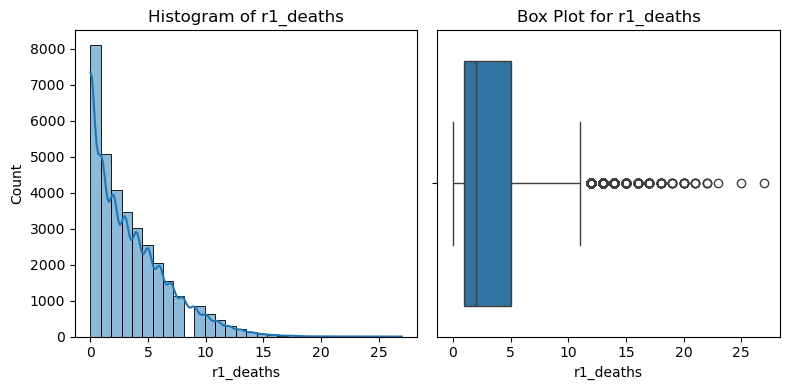

count    33723.000000
mean         3.275183
std          3.288359
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         27.000000
Name: r1_deaths, dtype: float64


In [55]:
create_stat_plots(train_data, 'r1_deaths')

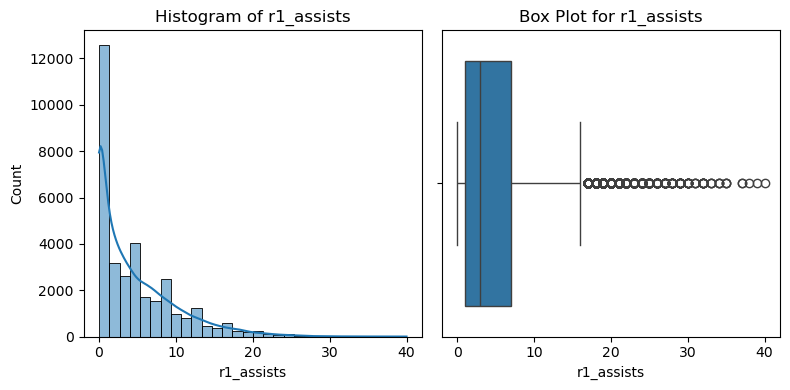

count    33723.000000
mean         4.666815
std          5.232222
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         40.000000
Name: r1_assists, dtype: float64


In [56]:
create_stat_plots(train_data, 'r1_assists')

Аналогично предыдущему.

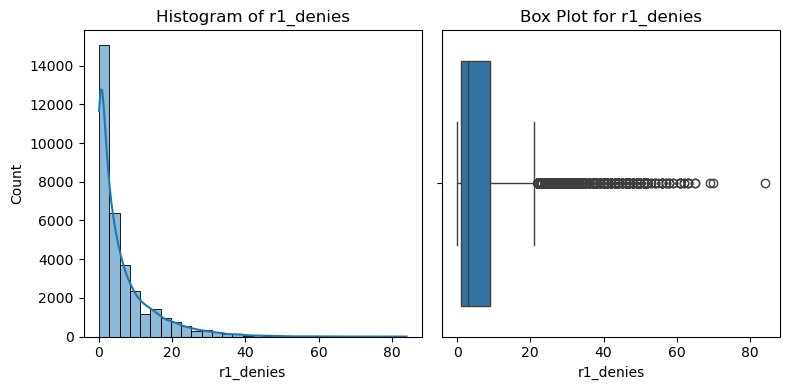

count    33723.000000
mean         6.271328
std          8.173442
min          0.000000
25%          1.000000
50%          3.000000
75%          9.000000
max         84.000000
Name: r1_denies, dtype: float64


In [58]:
create_stat_plots(train_data, 'r1_denies')

Сделать много денаев возможно, этим чаще занимаются мидеры и керри

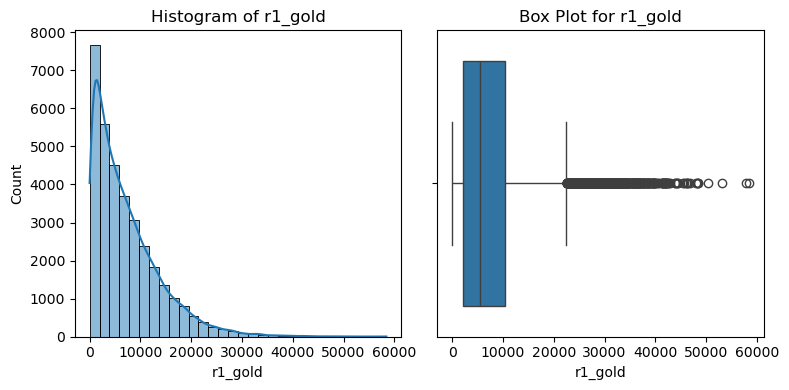

count    33723.000000
mean      7187.546926
std       6519.394877
min          2.000000
25%       2196.500000
50%       5421.000000
75%      10324.500000
max      58437.000000
Name: r1_gold, dtype: float64


In [60]:
create_stat_plots(train_data, 'r1_gold')

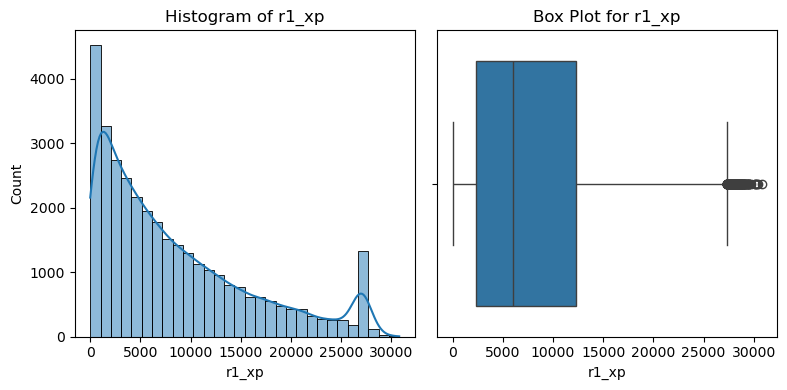

count    33723.000000
mean      8283.108146
std       7483.244811
min          0.000000
25%       2282.000000
50%       6004.000000
75%      12307.000000
max      30788.000000
Name: r1_xp, dtype: float64


In [61]:
create_stat_plots(train_data, 'r1_xp')

Странная аномалия около 27к опыта. Пока не знаю с чем это связано

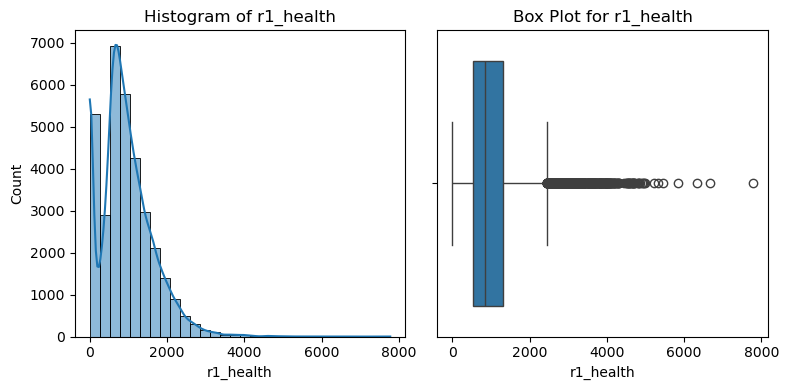

count    33723.000000
mean       942.220324
std        679.778928
min          0.000000
25%        528.500000
50%        841.000000
75%       1300.000000
max       7780.000000
Name: r1_health, dtype: float64


In [63]:
create_stat_plots(train_data, 'r1_health')

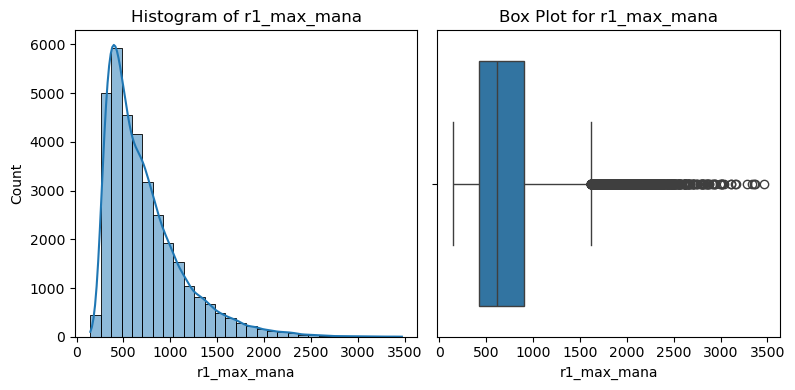

count    33723.000000
mean       719.922975
std        405.425453
min        146.937640
25%        422.937900
50%        614.938100
75%        900.938350
max       3467.941000
Name: r1_max_mana, dtype: float64


In [64]:
create_stat_plots(train_data, 'r1_max_mana')

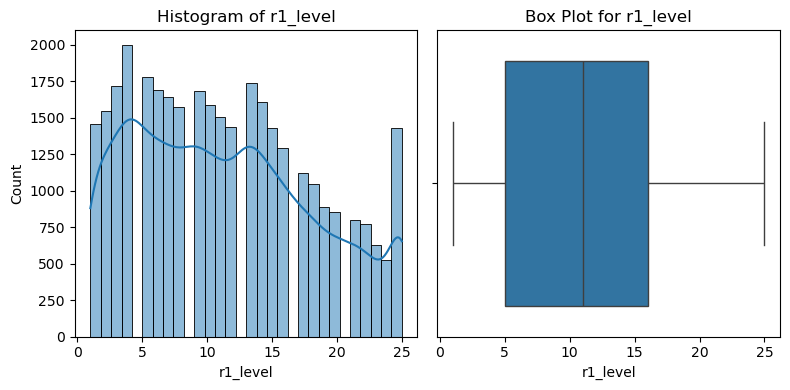

count    33723.000000
mean        11.295318
std          6.796163
min          1.000000
25%          5.000000
50%         11.000000
75%         16.000000
max         25.000000
Name: r1_level, dtype: float64


In [65]:
create_stat_plots(train_data, 'r1_level')

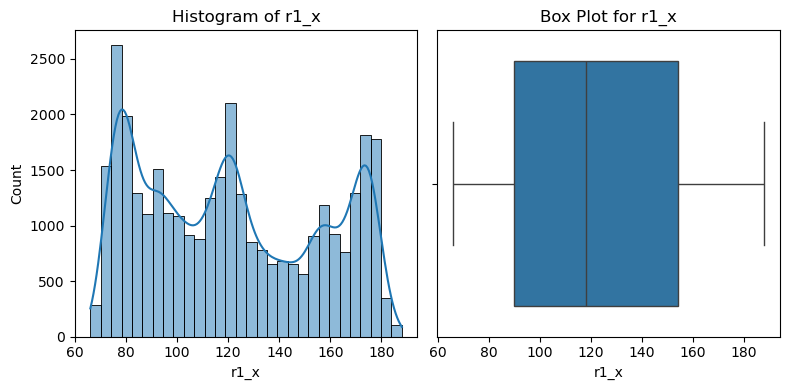

count    33723.000000
mean       121.183050
std         34.468398
min         66.000000
25%         90.000000
50%        118.000000
75%        154.000000
max        188.000000
Name: r1_x, dtype: float64


In [66]:
create_stat_plots(train_data, 'r1_x')

Непонятный признак

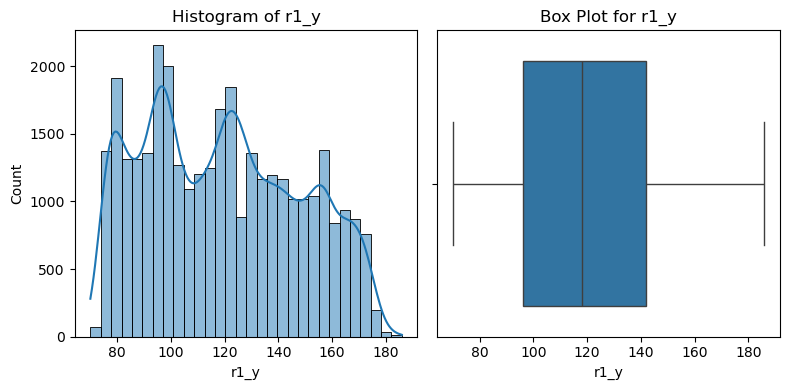

count    33723.000000
mean       119.139282
std         28.549696
min         70.000000
25%         96.000000
50%        118.000000
75%        142.000000
max        186.000000
Name: r1_y, dtype: float64


In [68]:
create_stat_plots(train_data, 'r1_y')

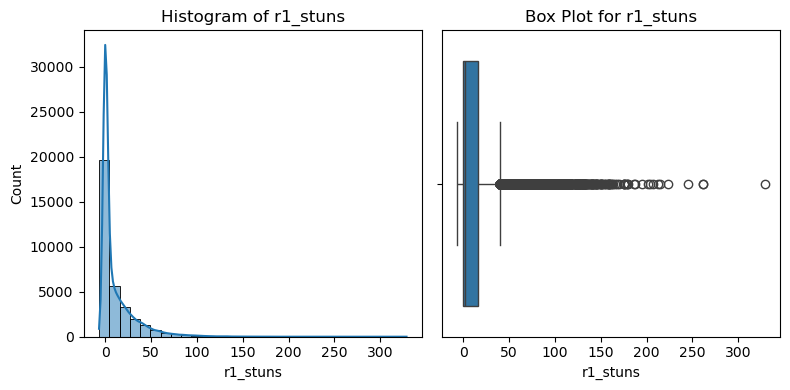

count    33723.000000
mean        11.717011
std         20.455503
min         -6.724344
25%          0.000000
50%          1.432989
75%         15.962536
max        328.755220
Name: r1_stuns, dtype: float64


In [69]:
create_stat_plots(train_data, 'r1_stuns')

Вот эти данные выглядят не очень реалистичными, однако не стоит исключать

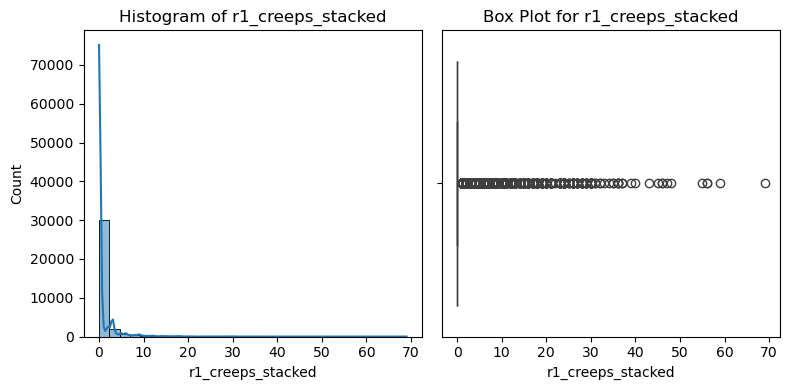

count    33723.000000
mean         0.791122
std          2.787444
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         69.000000
Name: r1_creeps_stacked, dtype: float64


In [71]:
create_stat_plots(train_data, 'r1_creeps_stacked')

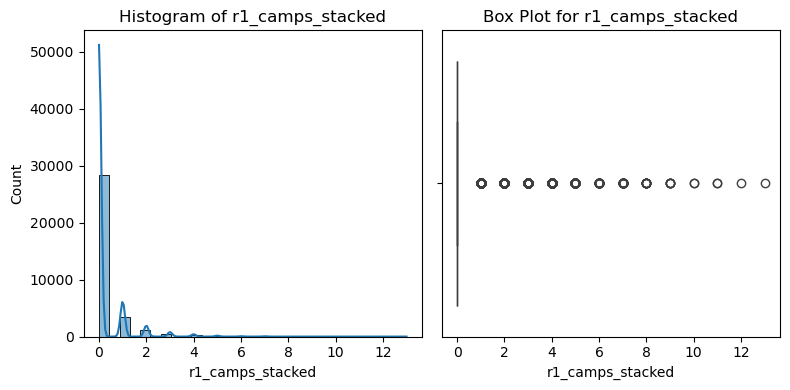

count    33723.000000
mean         0.264478
std          0.770930
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: r1_camps_stacked, dtype: float64


In [72]:
create_stat_plots(train_data, 'r1_camps_stacked')

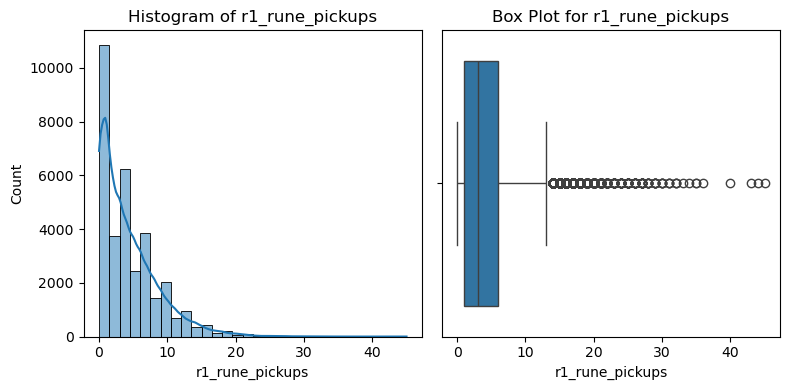

count    33723.000000
mean         4.347656
std          4.309975
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         45.000000
Name: r1_rune_pickups, dtype: float64


In [73]:
create_stat_plots(train_data, 'r1_rune_pickups')

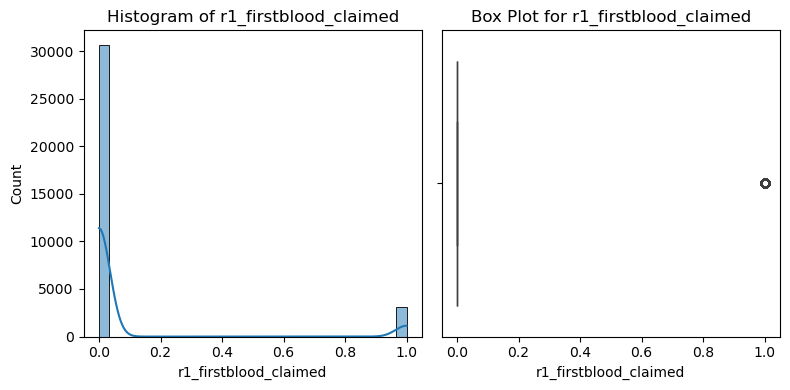

count    33723.000000
mean         0.091214
std          0.287917
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: r1_firstblood_claimed, dtype: float64


In [74]:
create_stat_plots(train_data, 'r1_firstblood_claimed')

In [75]:
for column in train_data.columns:
    if 'firstblood_claimed' in column:
        change_reg_to_cat(column)

Этот признак необходимо перевести в категориальные

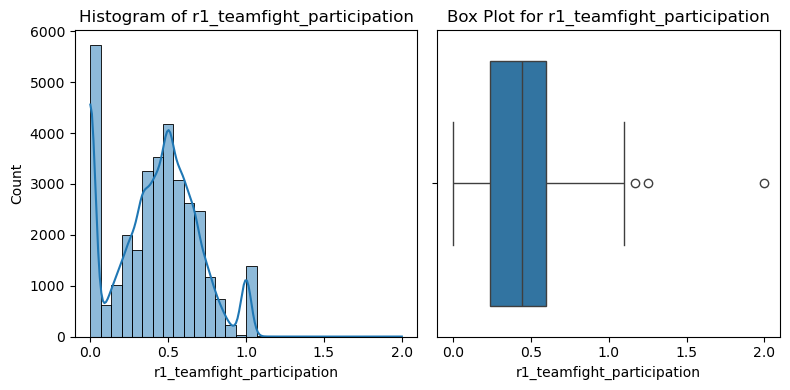

count    33723.000000
mean         0.418601
std          0.267443
min          0.000000
25%          0.240690
50%          0.444444
75%          0.600000
max          2.000000
Name: r1_teamfight_participation, dtype: float64


In [77]:
create_stat_plots(train_data, 'r1_teamfight_participation')

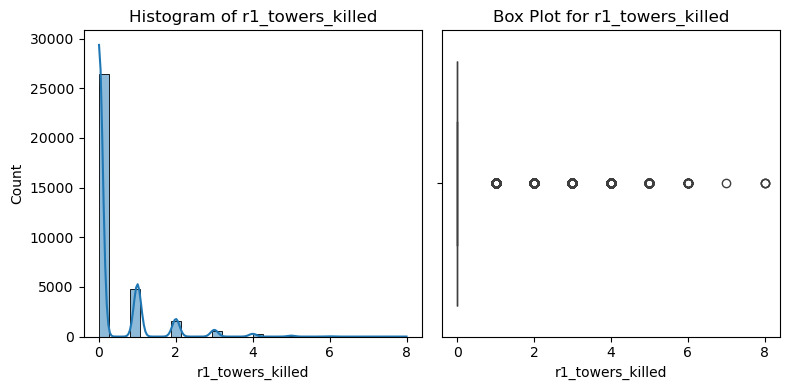

count    33723.000000
mean         0.336892
std          0.769572
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: r1_towers_killed, dtype: float64


In [78]:
create_stat_plots(train_data, 'r1_towers_killed')

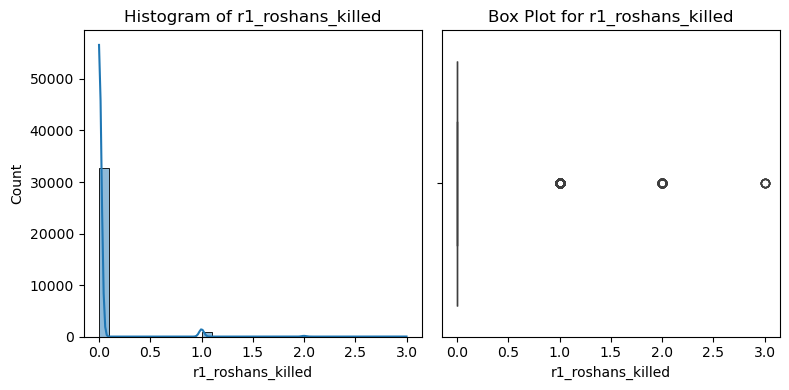

count    33723.000000
mean         0.029742
std          0.186042
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: r1_roshans_killed, dtype: float64


In [79]:
create_stat_plots(train_data, 'r1_roshans_killed')

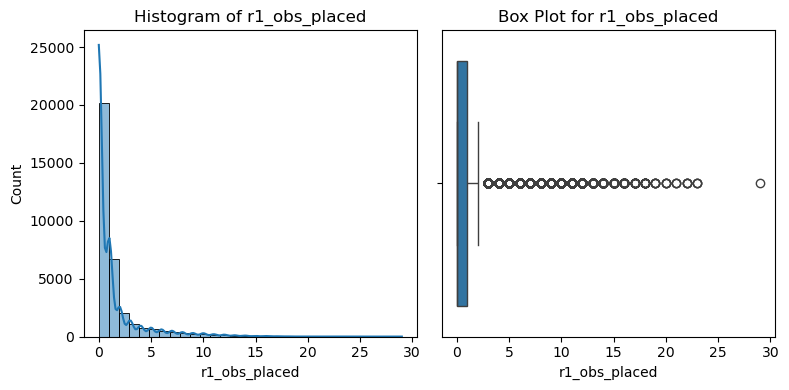

count    33723.000000
mean         1.209797
std          2.491613
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         29.000000
Name: r1_obs_placed, dtype: float64


In [80]:
create_stat_plots(train_data, 'r1_obs_placed')

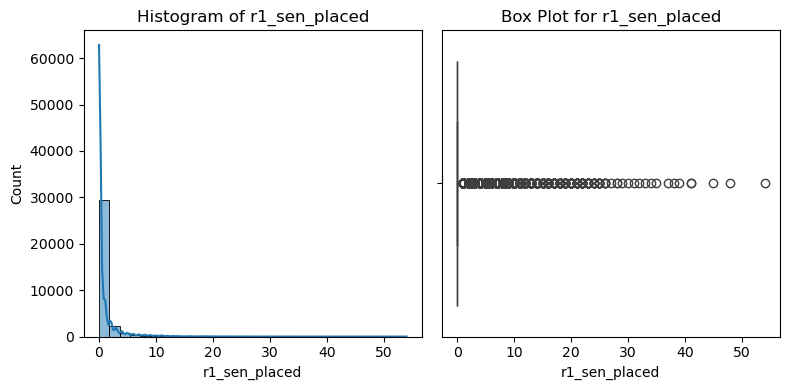

count    33723.000000
mean         0.767992
std          2.390418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         54.000000
Name: r1_sen_placed, dtype: float64


In [81]:
create_stat_plots(train_data, 'r1_sen_placed')

In [82]:
# create_stat_plots(train_data, 'duration')

In [83]:
# train_data[['game_time', 'duration']]

**Извлеку новые признаки**

In [85]:
train_data_extended = train_data.copy()
test_data_extended = test_data.copy()

In [86]:
radiant_list = ['r1', 'r2', 'r3', 'r4', 'r5']
dire_list = ['d1', 'd2', 'd3', 'd4', 'd5']
players_list = radiant_list + dire_list

In [87]:
for player in players_list:
    train_data_extended[player+"_gpm"] = np.where(
        train_data_extended['game_time'] != 0,
        train_data_extended[player+'_gold'] / train_data_extended['game_time'],
        0
    )
    numeric_features.append(player+"_gpm")

for player in players_list:
    test_data_extended[player+"_gpm"] = np.where(
        test_data_extended['game_time'] != 0,
        test_data_extended[player+'_gold'] / test_data_extended['game_time'],
        0
    )

Статистика ГПМ для каждого игрока

In [89]:
for player in players_list:
    train_data_extended[player+"_expm"] = np.where(
        train_data_extended['game_time'] != 0,
        train_data_extended[player+'_xp'] / train_data_extended['game_time'],
        0
    )
    numeric_features.append(player+"_expm")

for player in players_list:
    test_data_extended[player+"_expm"] = np.where(
        test_data_extended['game_time'] != 0,
        test_data_extended[player+'_xp'] / test_data_extended['game_time'],
        0
    )

Статистика ЭксПМ для каждого игрока

In [91]:
for player in players_list:
    train_data_extended[player+"_support_activity"] = train_data_extended[player+'_camps_stacked'] +  train_data_extended[player+'_obs_placed'] +  train_data_extended[player+'_sen_placed']
    numeric_features.append(player+"_support_activity")

for player in players_list:
    test_data_extended[player+"_support_activity"] = test_data_extended[player+'_camps_stacked'] +  test_data_extended[player+'_obs_placed'] +  test_data_extended[player+'_sen_placed']

Количество действий на должности саппорта у игрока

In [93]:
def team_firstblood(row):
    if any(row[col + '_firstblood_claimed'] == 1 for col in radiant_list):
        return 'radiant'
    if any(row[col + '_firstblood_claimed'] == 1 for col in dire_list):
        return 'dire'
    return None

In [94]:
train_data_extended['firstblood_team'] = train_data_extended.apply(team_firstblood, axis=1)
train_data_extended['firstblood_team'] = train_data_extended['firstblood_team'].fillna('Unknown')
categorical_features.append('firstblood_team')

test_data_extended['firstblood_team'] = test_data_extended.apply(team_firstblood, axis=1)
test_data_extended['firstblood_team'] = test_data_extended['firstblood_team'].fillna('Unknown')

In [95]:
# train_data_extended['next_roshan_team'] = train_data_extended['next_roshan_team'].fillna('Unknown')
# test_data_extended['next_roshan_team'] = test_data_extended['next_roshan_team'].fillna('Unknown')

Какая команда сделала firstblood

In [97]:
numeric_cols = train_data_extended.select_dtypes(include=[np.number])
inf_cols = numeric_cols.columns[np.isinf(numeric_cols).any()]

print('Для train_data_extended')
if len(inf_cols) > 0:
    print("Столбцы с бесконечными значениями:", inf_cols)
else:
    print("Бесконечные значения не найдены.")

numeric_cols = test_data_extended.select_dtypes(include=[np.number])
inf_cols = numeric_cols.columns[np.isinf(numeric_cols).any()]

print('Для test_data_extended')
if len(inf_cols) > 0:
    print("Столбцы с бесконечными значениями:", inf_cols)
else:
    print("Бесконечные значения не найдены.")

Для train_data_extended
Бесконечные значения не найдены.
Для test_data_extended
Бесконечные значения не найдены.


ПРоверка на наличие бесконечых значений

In [99]:
for feature in categorical_features:
    train_data_extended[feature] = train_data_extended[feature].astype('category')

for feature in categorical_features:
    test_data_extended[feature] = test_data_extended[feature].astype('category')

In [100]:
for feature in categorical_features_large:
    train_data_extended[feature] = train_data_extended[feature].astype('category')

for feature in categorical_features_large:
    test_data_extended[feature] = test_data_extended[feature].astype('category')

Замена типа данных у категориальных столбцов

**2. Предобработка данных**

In [103]:
# categorical_features.remove('match_id_hash')

In [104]:
X = train_data_extended.drop(['radiant_win', 'match_id_hash'], axis=1)
y = train_data_extended['radiant_win']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

X_test = test_data_extended.drop('match_id_hash', axis=1)

In [105]:
categorical_features.remove('match_id_hash')

Выделяю признаки и целевую переменную, а также разбиваю выборку на тренировочную и тестовую

In [107]:
display(X_train.shape)
display(X_test.shape)

(26978, 276)

(5952, 276)

После разделения датафремы имеют следующий размер

In [109]:
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
categorical_large_transformer = TargetEncoder()

Для масштабирования числовых признаков использую MinMaxScaler, для кодирования категориальных - OneHotEncoder, для кодировки больших категориальных признаков (где много категорий) - 

In [111]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('cat_large', categorical_large_transformer, categorical_features_large)
    ]
)

**3. Построение и обучение моделей**

In [113]:
def create_pipeline(model):
    # Функция создания пайплайна
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

In [114]:
def metrics_report(pipeline, X, y, cv):
    # Функция расчета метрик
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    y_prob = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
    
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)
    
    return precision, recall, f1, accuracy, roc_auc

In [115]:
def add_best_metrics_to_df(df, model_type, best_params, accuracy, precision, recall, f1, roc_auc):
    # Функция добавления метрик лучшей модели в сьорный датафоейм
    new_row = pd.DataFrame([{
        'BestModel': model_type,
        'BestParameters': best_params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc
    }])
    
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [116]:
def train_dummy_model(X_train, y_train, X_val, y_val):
    # Функция обучения дамми модели
    model = DummyClassifier(strategy='most_frequent')

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0) 
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    metrics = {
        'BestModel': 'dummy_model',
        'BestParameters': 'N/A',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc
    }
    
    return metrics

In [117]:
def objective_logistic_regression(trial):
    # Логистическая регрессия
    C = trial.suggest_float('C', 1e-3, 1e3, log=True) 
    model = LogisticRegression(C=C, random_state=RANDOM_STATE, solver='liblinear')
    pipeline = create_pipeline(model)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    precision, recall, f1, accuracy, roc_auc = metrics_report(pipeline, X_train, y_train, cv)
    
    trial.set_user_attr('model_type', 'logistic_regression')
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('recall', recall)
    trial.set_user_attr('f1', f1)
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('roc_auc', roc_auc)
    
    return roc_auc 

In [118]:
def objective_catboost_classification(trial):
    # Градиентный бустинг
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    iterations = trial.suggest_int('iterations', 100, 1000)
    
    model = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        task_type='CPU',
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    pipeline = create_pipeline(model)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    try:
        precision, recall, f1, accuracy, roc_auc = metrics_report(pipeline, X_train, y_train, cv)
        trial.set_user_attr('model_type', 'catboost')
        trial.set_user_attr('precision', precision)
        trial.set_user_attr('recall', recall)
        trial.set_user_attr('f1', f1)
        trial.set_user_attr('accuracy', accuracy)
        trial.set_user_attr('roc_auc', roc_auc)
        return roc_auc
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('inf')

In [119]:
columns = ['BestModel', 'BestParameters', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
metrics_df = pd.DataFrame(columns=columns)

Объявление датафрейма с метриками лучших моделей

In [120]:
dummy_metrics = train_dummy_model(X_train, y_train, X_val, y_val)

dummy_metrics_df = pd.DataFrame([dummy_metrics])
metrics_df = pd.concat([metrics_df, dummy_metrics_df], ignore_index=True)

C:\Users\miks9\AppData\Local\Temp\ipykernel_15792\1926768021.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, dummy_metrics_df], ignore_index=True)


Обучение дамми модели

In [121]:
study_logistic = optuna.create_study(direction='maximize')

for _ in tqdm(range(N_TRIALS), desc="Оптимизация линейной модели"):
    study_logistic.optimize(objective_logistic_regression, n_trials=1)

best_logistic_trial = study_logistic.best_trial

metrics_df = add_best_metrics_to_df(
    metrics_df,
    best_logistic_trial.user_attrs['model_type'],
    best_logistic_trial.params,
    best_logistic_trial.user_attrs['precision'],
    best_logistic_trial.user_attrs['recall'],
    best_logistic_trial.user_attrs['f1'],
    best_logistic_trial.user_attrs['accuracy'],
    best_logistic_trial.user_attrs['roc_auc']
)

[I 2024-11-07 09:11:59,280] A new study created in memory with name: no-name-6b0df97b-f055-43bf-8655-4bf29b0837f9
Оптимизация линейной модели: 100%|██████████| 25/25 [11:28<00:00, 27.54s/it]
C:\Users\miks9\AppData\Local\Temp\ipykernel_15792\2777639304.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Обучение логистической регрессии

Лучшая модель показала метрику ROC AUC = 0.819

In [123]:
study_catboost = optuna.create_study(direction='maximize')

for _ in tqdm(range(N_TRIALS), desc="Оптимизация CatBoost"):
    study_catboost.optimize(objective_catboost_classification, n_trials=1)

best_catboost_trial = study_catboost.best_trial

metrics_df = add_best_metrics_to_df(
    metrics_df,
    best_catboost_trial.user_attrs['model_type'],
    best_catboost_trial.params,
    best_catboost_trial.user_attrs['precision'],
    best_catboost_trial.user_attrs['recall'],
    best_catboost_trial.user_attrs['f1'],
    best_catboost_trial.user_attrs['accuracy'],
    best_catboost_trial.user_attrs['roc_auc']
)

[I 2024-11-07 09:23:27,761] A new study created in memory with name: no-name-5286d86e-59c9-4593-8d4f-df4790c6400f
Оптимизация CatBoost: 100%|██████████| 25/25 [2:57:27<00:00, 425.92s/it]


Обучение градиентного бустинга

In [124]:
metrics_df

BestModel                                     BestParameters  \
0          dummy_model                                                N/A   
1  logistic_regression                         {'C': 0.37498245449742473}   
2             catboost  {'learning_rate': 0.028138780553135623, 'depth...   

   Accuracy  Precision    Recall        F1   ROC-AUC  roc_auc  
0  0.514752   0.514752  1.000000  0.679652       NaN      0.5  
1  0.731238   0.778076  0.753930  0.733116  0.819247      NaN  
2  0.731083   0.764038  0.747197  0.728334  0.816527      NaN

В результате лучшую метрику ROC-AUC показала модель логистической регрессии 

**4. Тестирование лучшей модели**

Поиск лучшей модели и ее инициализация 

In [133]:
best_model_row = metrics_df.loc[metrics_df['ROC-AUC'].idxmax()]
print(best_model_row)

model_type = best_model_row['BestModel']
best_params = best_model_row['BestParameters']

BestModel                logistic_regression
BestParameters    {'C': 0.37498245449742473}
Accuracy                            0.731238
Precision                           0.778076
Recall                               0.75393
F1                                  0.733116
ROC-AUC                             0.819247
roc_auc                                  NaN
Name: 1, dtype: object


In [135]:
if model_type == 'logistic_regression':
    best_model = LogisticRegression(**best_params, random_state=RANDOM_STATE, max_iter=1000)
elif model_type == 'catboost':
    best_model = CatBoostClassifier(**best_params, task_type='CPU', random_state=RANDOM_STATE, verbose=0)
elif model_type == 'dummy_model':
    best_model = DummyClassifier(strategy='most_frequent')
else:
    raise ValueError("Неизвестный тип модели")

In [137]:
best_pipeline = create_pipeline(best_model)

In [139]:
best_pipeline.fit(X_train, y_train)
y_pred_test = best_pipeline.predict(X_test)

In [140]:
y_pred_test

array([ True,  True,  True, ..., False, False,  True])

Предсказание на тестовой выборке

In [169]:
final_data = test_data_extended[['match_id_hash']].copy()
final_data['Target'] = y_pred_test
final_data['Target'] = final_data['Target'].replace({True: 1, False: 0})
final_data = final_data.rename(columns={'match_id_hash': 'ID'})

C:\Users\miks9\AppData\Local\Temp\ipykernel_15792\1027655365.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_data['Target'] = final_data['Target'].replace({True: 1, False: 0})


In [173]:
file_path = 'final_data.csv'
final_data.to_csv(file_path, index=False)

Выгрузка конечного датасета для каггл

**Выводы**  
В результате выполненных работ была проанализированна дата, выбросы было решено не удалять, т.к. их природа реальна. Построены графики гистограмм для каждого признака. Добавлены новые признаки player_gpm, player_expm, first-blood_team.  
Для анализва выбраны 3 модели - дамми модель, логистическая регрессия и градиентнвый бустинг (катбуст). В результате кросс валидачии лучшую метрику ROC-AUC показала логистическая регрессия.  
Для тестовых данных выбрана лучшая модель логистической регрессии. При тестовой раюоте модели получилось достичь метрики ROC-AUC 0,74 (данные с каггл (https://www.kaggle.com/competitions/workshop-dota-2-w-inner-prediction/leaderboard?)